## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, make_scorer
#parallel backend
from sklearn.utils import parallel_backend


## Data Understanding

In [2]:
#get a basic understanding of data and how it works together

In [3]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
def explore_data(df):
    """
    prints all basic infos about a dataframe
    
    Args:
        df: any pandas dataframe
    Returns:
        None
    
    """
    #get basic shape of dataframe
    shape = df.shape
    print('shape: {}'.format(shape))
    print('------------------\n')
    
    #check for dtypes and missing values
    info = df.info()
    print(info)
    print('------------------\n')
    
    #check numeric variables in dataframe
    description = df.describe()
    print(description)
    print('------------------\n')
    
    for column in train_data.columns:
        print(column)
        print(train_data[column].unique())
        print('------------------\n')
    
    if 'sns' not in dir():
        import seaborn as sns
        sns.set()
        #check correlation of numeric variables in dataframe
        print('Correlation: \n')
        heatmap = sns.heatmap(df.corr(), annot=True, fmt='.2f')
    else:
        print('Correlation: \n')
        heatmap = sns.heatmap(df.corr(), annot=True, fmt='.2f')

shape: (84534, 10)
------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB
None
------------------

                  ID      purchase            V1            V2            V3  \
count   84534.000000  84534.000000  84534.000000  84534.000000  84534.000000   
mean    62970.972413      0.012303      1.500662     29.973600      0.000190   
std     36418.440539      0.110234      0.868

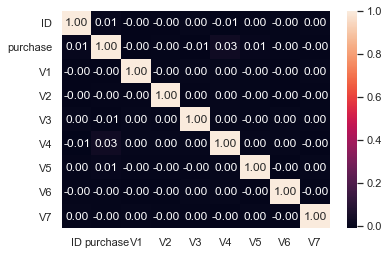

In [5]:
explore_data(train_data)

We'll definitely have to take care of "Promotion" and turn it into 0 and 1
Otherwise there are no null values, which is very good and no missing values either

## Prepare the Data - Cleaning

In [6]:
#as mentioned, we need to take care of the Promotion column
train_data = train_data.replace({'Promotion': {'Yes': 1, 'No': 0}})
train_data['Promotion'].unique()

array([0, 1])

In [7]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,0,0,2,30.443518,-1.165083,1,1,3,2
1,3,0,0,3,32.159350,-0.645617,2,3,2,2
2,4,0,0,2,30.431659,0.133583,1,1,4,2
3,5,0,0,0,26.588914,-0.212728,2,1,4,2
4,8,1,0,3,28.044332,-0.385883,1,1,2,2


In [8]:
#create a checkpoint
cleaned_data = train_data.copy()

## Statistically Significant Difference

In [9]:
cleaned_data.groupby('Promotion')['purchase'].value_counts()

Promotion  purchase
0          0           41851
           1             319
1          0           41643
           1             721
Name: purchase, dtype: int64

### Invariant Metrics

In [10]:
#there are only two groups, those who received a promotion, and those who did not
#so there is one control group and one experiment group
#since we can assume, that the numbers of participants in the group are roughly the same
n_obs = cleaned_data.shape[0]
n_control = cleaned_data["Promotion"].value_counts().loc[0]
n_exper = cleaned_data["Promotion"].value_counts().loc[1]

print('n_obs: {}'.format(n_obs))
print('n_control: {}'.format(n_control))
print('n_exper: {}'.format(n_exper))

n_obs: 84534
n_control: 42170
n_exper: 42364


In [11]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print('std dev: {}'.format(sd))
print('z-score: {}'.format(z))
print('p-value: ', 2 * stats.norm.cdf(z))

std dev: 145.3736564856233
z-score: -0.6638066506192843
p-value:  0.5068140685419046


### Evaluation Metrics

#### Incremental Response Rate (IRR)

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [12]:
def iir(df):
    """
    Args:
        df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    Returns:
        The evaluation metric IIR
    """        
    df['purchase'] = df['purchase'].astype('int32')        
    purch_control = (df.groupby('Promotion')['purchase'].sum()).loc[0]
    purch_treat = df.groupby('Promotion')['purchase'].sum().loc[1]   
    cust_treat = df["Promotion"].value_counts().loc[1]
    cust_control = df["Promotion"].value_counts().loc[0]
    
    return (purch_treat / cust_treat) - (purch_control / cust_control)

In [13]:
iir(cleaned_data)

0.009454547819772702

##### Net Incremental Revenue (NIR)

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [14]:
def nir(df):
    """
    Args: 
        df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    Returns:
        The evaluation metric NIR
    """            
    df['purchase'] = df['purchase'].astype('int32')    
    purch_control = (df.groupby('Promotion')['purchase'].sum()).loc[0]
    purch_treat = (df.groupby('Promotion')['purchase'].sum()).loc[1]    
    cust_treat = df["Promotion"].value_counts().loc[1]
    
    return (10 * purch_treat - 0.15 * cust_treat) - (10 * purch_control)

In [15]:
nir(cleaned_data)

-2334.5999999999995

## Results of the Experiment

The IRR is slightly in the positive, given that the puchases between groups who received a promotion and did not do not differ that much.

The Net Incremental Revenue showcases a loss of about 2334 $ from the training data set, given that each promotion costs 0.15 ¢ and there is no substantial difference in purchase behavior with a promotion.

Overall, this experiments does not seem like a success with the promotions being dealt out as is, as random. We need to decide which recepients are prone do a purchase once they received a promotion. For that, we will use a classifier.

## Classifier Model

In [85]:
def build_model():
    """
    Creates pipeline of model and parameters to optimize it
    Args:
        - None
    Returns:
        - cv: grid search object
    """
    #build pipeline
    pipeline = Pipeline([
        ('clf', RandomForestClassifier(random_state=0, 
                                       n_jobs=-1, 
                                       class_weight="balanced"))    
    ])
    
    #gridsearch parameters
    parameters = {
        'clf__n_estimators' : [100, 200, 500],
        'clf__max_features' : ['auto', 'sqrt', 'log2'],
        'clf__max_depth' : [2, 3, 6, 7, 10],
        'clf__criterion' : ['gini', 'entropy'],
        'clf__bootstrap' : [True, False],
        'clf__min_samples_split' : [2, 4, 6, 8, 10]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=2)
    
    return cv

In [86]:
#define input and output metrics
X = cleaned_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = cleaned_data['purchase']

In [87]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
#build model
print('Building model...')
model = build_model()
print('model built!')

#train model
print('Training model...')
model.fit(X_train, y_train)
print('model trained!')

Building model...
model built!
Training model...
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 66.5min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed: 81.0min finished


model trained!


In [89]:
#print out optimal parameter combination
print(model.best_score_, model.best_params_)

0.8827834424725379 {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__min_samples_split': 4, 'clf__n_estimators': 500}


In [94]:
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.52730889574226


## Test

In [90]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X = df.values
    y_pred = model.predict(X)    
    promotion = np.where(y_pred == 1, "Yes", "No")
    
    return promotion

In [91]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0197.

Your nir with this strategy is 128.50.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01970168131691308, 128.5)